Pump and Dump Events: 0
Is Pump and Dump: False


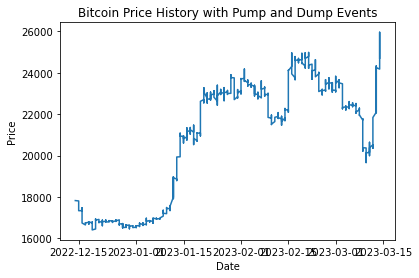

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import json

coin_gecko_api_url = "https://api.coingecko.com/api/v3/coins/"
days_to_analyze = 90
coin_id = "bitcoin"  # Replace with desired coin ID
price_threshold = 0.1  # Set threshold, e.g., 0.1 for 10% price change
volume_threshold = 0.1  # Set threshold, e.g., 0.1 for 10% volume change
moving_average_window = 3  # Set moving average window

def get_coin_history(coin_id, days_to_analyze):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_to_analyze)
    
    response = requests.get(f"{coin_gecko_api_url}{coin_id}/market_chart?vs_currency=usd&days={days_to_analyze}")
    data = json.loads(response.text)
    
    df = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms").dt.date
    df["volume"] = [x[1] for x in data["total_volumes"]]
    
    return df

def detect_pump_and_dump(data, price_threshold, volume_threshold, moving_average_window):
    data["price_pct_change"] = data["price"].pct_change()
    data["volume_pct_change"] = data["volume"].pct_change()
    
    data["price_ma"] = data["price"].rolling(window=moving_average_window).mean()
    data["volume_ma"] = data["volume"].rolling(window=moving_average_window).mean()
    
    data["pump"] = (data["price_pct_change"] >= price_threshold) & (data["volume_pct_change"] >= volume_threshold)
    data["dump"] = (data["price_pct_change"] < -price_threshold) & (data["volume_pct_change"] >= volume_threshold)
    
    data["pump_and_dump"] = data["pump"].shift(1) & data["dump"]
    
    events_count = data["pump_and_dump"].sum()
    is_pump_and_dump = events_count > 0
    
    return events_count, is_pump_and_dump

price_data = get_coin_history(coin_id, days_to_analyze)
events_count, is_pump_and_dump = detect_pump_and_dump(price_data, price_threshold, volume_threshold, moving_average_window)

print(f"Pump and Dump Events: {events_count}")
print(f"Is Pump and Dump: {is_pump_and_dump}")

plt.plot(price_data["date"], price_data["price"])
plt.scatter(price_data[price_data["pump_and_dump"]]["date"], price_data[price_data["pump_and_dump"]]["price"], color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{coin_id.capitalize()} Price History with Pump and Dump Events")
plt.show()
